## Generate flux distribution PDFs
This notebooks loads in data from ERA5 + GCM precomputed fluxes (using their respective notebooks)

In [1]:
import matplotlib.pyplot as plt 

plt.rcParams.update({
    'font.family':"sans-serif",
    'font.style':'normal',
    'font.size':19,
    'figure.figsize':(8,8)
})


In [2]:
import xarray as xr 
import numpy as np 
import os 
FIGDIR = 'figures'
DATADIR = 'data'
exp = 'AD99 c0=0 (include unbroken)'
expcode = 'always_include_unbroken_1year'
ERA5_DATASET = f"{DATADIR}/era5_{expcode}.nc"
GCM_DATASET = f"{DATADIR}/mima_gwf_{expcode}.nc"

fluxes = ['gw_flux_eastward','gw_flux_westward','gw_flux_northward','gw_flux_southward','z']

ds_era5 = xr.open_dataset(ERA5_DATASET)
ds_gcm = xr.open_dataset(GCM_DATASET)

ds_era5 = ds_era5[fluxes]
ds_gcm = ds_gcm[fluxes]

In [3]:
from ad99py.masks import list_basins
list_basins(dir=DATADIR)

['tropical_atlantic',
 'extratropical_atlantic',
 'extratropical_pacific',
 'indian',
 'tropical_pacific',
 'southern_ocean']

In [4]:
from ad99py.masks import mask_dataset
BASINS = None
basin_title = ""
# BASINS = ['tropical_atlantic']
# basin_title = "Tropical Atlantic"
# can also mask by basin by passing a "basin"
ds_era5 = mask_dataset(ds_era5,dir=DATADIR,basins=BASINS)
ds_gcm = mask_dataset(ds_gcm,dir=DATADIR,basins=BASINS)

In [5]:
ds_era5 = ds_era5.transpose('time','points','level')
ds_gcm = ds_gcm.transpose('time','points','level')

In [6]:
era5_lat = np.broadcast_to(ds_era5.latitude.data[None,:,None],ds_era5.z.shape)
gcm_lat = np.broadcast_to(ds_gcm.latitude.data[None,:,None],ds_gcm.z.shape)

In [7]:
def net(ds):
    return np.sqrt((ds.gw_flux_eastward + ds.gw_flux_westward)**2 + (ds.gw_flux_northward + ds.gw_flux_southward)**2)

def total(ds):
    return np.abs(ds.gw_flux_eastward ) + np.abs(ds.gw_flux_westward ) + np.abs(ds.gw_flux_southward ) + np.abs(ds.gw_flux_northward )

net_era5 = net(ds_era5)
net_gcm = net(ds_gcm)
total_era5 = total(ds_era5)
total_gcm = total(ds_gcm)

### Loon

In [8]:
from ad99py.loon import loon_data
LOON_DATA = loon_data(basins=BASINS,path='data/loon')
LOON_DATA.keys()

dict_keys(['u_flux_ntv', 'u_flux_ptv', 'v_flux_ntv', 'v_flux_ptv', 'u_flux_abs', 'v_flux_abs', 'u_flux_net', 'v_flux_net', 'net_flux', 'abs_flux'])

### unravel and flatten ERA5

In [9]:
def filter_scale(fluxes):
    fluxes = np.abs(fluxes)
    fluxes = fluxes[fluxes > 1e-8] # zeros mess with the PDF so lets remove these
    return fluxes*1000

In [10]:
from scipy.stats import skew 

def plot_mass(era5,gcm,loon=None,ax=None):
    if ax is None:
        _,ax = plt.subplots()
    bin_edges = np.linspace(0,10,50)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])*0.5
    gcm_hist, _ = np.histogram(np.abs(gcm),bins=bin_edges,density=True)
    era5_hist,_ = np.histogram(np.abs(era5),bins=bin_edges,density=True)
    dx = bin_edges[1] -bin_edges[0]
    gcm_hist *= dx
    era5_hist *= dx
    ax.bar(bin_centers,era5_hist,width=dx,label='ERA5',color='C0',alpha=0.3)
    ax.bar(bin_centers,gcm_hist,width=dx,label='GCM',color='C1',alpha=0.3)
    if loon:
        loon_hist, _ = np.histogram(np.abs(LOON_DATA[loon]),bins=bin_edges,density=True)
        loon_hist *= dx
        ax.bar(bin_centers,loon_hist,width=dx,label='Loon',color='red',alpha=0.3)
    ax.set_xlabel("Momentum Flux ($\\textit{mPa}$)")
    ax.set_ylabel("Probability")
    ax.legend()
    ax.set_yscale('log')
    return ax

def plot_density(era5,gcm,loon=None,ax=None):
    if ax is None:
        _,ax = plt.subplots()
    bin_edges = np.linspace(0,10,100)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])*0.5
    gcm_hist, _ = np.histogram(np.abs(gcm),bins=bin_edges,density=True)
    era5_hist,_ = np.histogram(np.abs(era5),bins=bin_edges,density=True)
    ax.plot(bin_centers,era5_hist,label='ERA5',color='C0')
    ax.plot(bin_centers,gcm_hist,label='GCM',color='C1')

    if loon:
        loon_hist, _ = np.histogram(np.abs(LOON_DATA[loon]),bins=bin_edges,density=True)
        ax.plot(bin_centers,loon_hist,label='Loon',color='red',linestyle='--')
    ax.set_xlabel("Momentum Flux ($\\mathit{mPa}$)")
    ax.set_ylabel("Probability Density")
    ax.legend()
    return ax

def plot_density_ylog(era5,gcm,loon=None,ax=None):
    if ax is None:
        _, ax = plt.subplots()
    bin_edges = np.linspace(0,2,100)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])*0.5
    gcm_hist, _ = np.histogram(np.abs(gcm),bins=bin_edges,density=True)
    era5_hist,_ = np.histogram(np.abs(era5),bins=bin_edges,density=True)
    ax.plot(bin_centers,era5_hist,label='ERA5',color='C0')
    ax.plot(bin_centers,gcm_hist,label='GCM',color='C1')
    if loon:
        loon_hist, _ = np.histogram(np.abs(LOON_DATA[loon]),bins=bin_edges,density=True)
        ax.plot(bin_centers,loon_hist,label='Loon',color='red',linestyle='--')
    ax.set_xlabel("Momentum Flux ($\\mathit{mPa}$)")
    ax.set_ylabel("Probability Density")
    ax.legend()
    ax.set_yscale('log')
    return ax

def plot_logx_density(era5,gcm,loon=None,ax=None):
    if ax is None:
        _,ax = plt.subplots()
    bin_edges = np.linspace(-3,3,100)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])*0.5
    gcm_hist, _ = np.histogram(np.log10(np.abs(gcm)),bins=bin_edges,density=True)
    era5_hist,_ = np.histogram(np.log10(np.abs(era5)),bins=bin_edges,density=True)
    ax.plot(bin_centers,era5_hist,label='ERA5',color='C0')
    ax.plot(bin_centers,gcm_hist,label='GCM',color='C1')

    if loon:
        loon_hist, _ = np.histogram(np.log10(np.abs(LOON_DATA[loon])),bins=bin_edges,density=True)
        ax.plot(bin_centers,loon_hist,label='Loon',color='red',linestyle='--')
    ax.set_xlabel("Log10 of Momentum Flux in $\\mathit{mPa}$")
    ax.set_ylabel("Probability Density")
    ax.legend()
    return ax


def gaussian(x,mu,sigma):
    return np.exp(-0.5*(x-mu)**2/(sigma**2))/np.sqrt(2*np.pi*sigma*sigma)

def plot_logx_density_w_fit(era5,gcm,loon=None,ax=None):
    if ax is None:
        _,ax = plt.subplots()
    bin_edges = np.linspace(-3,3,100)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])*0.5

    gcm_log10 = np.log10(np.abs(gcm))
    era5_log10 = np.log10(np.abs(era5))

    gcm_hist, _ = np.histogram(gcm_log10,bins=bin_edges,density=True)
    era5_hist,_ = np.histogram(era5_log10,bins=bin_edges,density=True)
    ax.plot(bin_centers,era5_hist,label='ERA5',color='C0')
    ax.plot(bin_centers,gcm_hist,label='GCM',color='C1')

    mu_gcm,sigma_gcm = gcm_log10.mean(),gcm_log10.std()
    mu_era5,sigma_era5 = era5_log10.mean(), era5_log10.std()

    ax.plot(bin_centers, gaussian(bin_centers,mu_gcm,sigma_gcm),color='C1',linestyle='--')
    ax.plot(bin_centers, gaussian(bin_centers, mu_era5,sigma_era5),color='C0',linestyle='--')

    if loon:
        loon_hist, _ = np.histogram(np.log10(np.abs(LOON_DATA[loon])),bins=bin_edges,density=True)
        ax.plot(bin_centers,loon_hist,label='Loon',color='red',linestyle='--')
    ax.set_xlabel("Log10 of Momentum Flux in $\\mathit{mPa}$")
    ax.set_ylabel("Probability Density")
    ax.legend()
    return ax


def total_sums(era5, gcm, loon=None):
    era5_sum = np.sum(np.abs(era5))
    gcm_sum = np.sum(np.abs(gcm))
    if loon:
        loon_sum = np.sum(np.abs(LOON_DATA[loon]))
        return era5_sum, gcm_sum, loon_sum
    else:
        return era5_sum, gcm_sum 

def gw_medians(era5,gcm,loon=None):
    era5_norm_median = np.median(np.abs(era5))
    gcm_norm_median = np.median(np.abs(gcm))
    era5_log_median = np.median(np.log10(np.abs(era5)))
    gcm_log_median = np.median(np.log10(np.abs(gcm)))

    if loon: 
        loon_median = np.median(np.abs(LOON_DATA[loon]))
        loon_log_median = np.median(np.abs(LOON_DATA[loon]))
        return (era5_norm_median,gcm_norm_median,loon_median),(era5_log_median,gcm_log_median,loon_log_median)
    else:
        return (era5_norm_median,gcm_norm_median),(era5_log_median,gcm_log_median)

def gw_means(era5,gcm,loon=None):
    era5_norm_mean = np.mean(np.abs(era5))
    gcm_norm_mean = np.mean(np.abs(gcm))
    era5_log_mean = np.mean(np.log10(np.abs(era5)))
    gcm_log_mean = np.mean(np.log10(np.abs(gcm)))

    if loon: 
        loon_mean = np.mean(np.abs(LOON_DATA[loon]))
        loon_log_mean = np.mean(np.abs(np.log10(LOON_DATA[loon])))
        return (era5_norm_mean,gcm_norm_mean,loon_mean),(era5_log_mean,gcm_log_mean,loon_log_mean)
    else:
        return (era5_norm_mean,gcm_norm_mean),(era5_log_mean,gcm_log_mean)
        
def gw_std(era5,gcm,loon=None):
    era5_norm_std = np.std(np.abs(era5))
    gcm_norm_std = np.std(np.abs(gcm))
    era5_log_std = np.std(np.log10(np.abs(era5)))
    gcm_log_std = np.std(np.log10(np.abs(gcm)))

    if loon: 
        loon_std = np.std(np.abs(LOON_DATA[loon]))
        loon_log_std = np.std(np.abs(LOON_DATA[loon]))
        return (era5_norm_std,gcm_norm_std,loon_std),(era5_log_std,gcm_log_std,loon_log_std)
    else:
        return (era5_norm_std,gcm_norm_std),(era5_log_std,gcm_log_std)

def gw_skews(era5,gcm,loon=None):
    era5_norm_skew =skew(np.abs(era5))
    gcm_norm_skew =skew(np.abs(gcm))
    era5_log_skew =skew(np.log10(np.abs(era5)))
    gcm_log_skew =skew(np.log10(np.abs(gcm)))

    if loon: 
        loon_skew = skew(np.abs(LOON_DATA[loon]))
        loon_log_skew = skew(np.abs(LOON_DATA[loon]))
        return (era5_norm_skew,gcm_norm_skew,loon_skew),(era5_log_skew,gcm_log_skew,loon_log_skew)
    else:
        return (era5_norm_skew,gcm_norm_skew),(era5_log_skew,gcm_log_skew)


def pretty_print_stats(era5,gcm,loon):
    print("------------ Statistics ------------")
    print('--------------- Total --------------')
    print('ERA5 ----------- GCM ---------- Loon')
    era5_tot,gcm_tot,loon_tot = total_sums(era5,gcm,loon)
    print(f'{era5_tot/1000:.2f} Pa    {gcm_tot/1000:.2f} Pa       {loon_tot/1000:.2f} Pa')
    print(f'{100*era5_tot/loon_tot:.2f} %        {100*gcm_tot/loon_tot:.2f} %          100%')

    print('--------------- Mean  --------------')
    print('ERA5 ----------- GCM ---------- Loon')
    (era5_mean,gcm_mean,loon_mean),(era5_mean_log,gcm_mean_log,loon_mean_log) = gw_means(era5,gcm,loon)
    print(f'{era5_mean:.2f} mPa    {gcm_mean:.2f} mPa       {loon_mean:.2f} mPa')
    print(f'{100*era5_mean/loon_mean:.2f} %        {100*gcm_mean/loon_mean:.2f} %          100%')
    print(f'{era5_mean_log:.2f} logmPa    {gcm_mean_log:.2f} logmPa       {loon_mean_log:.2f} logmPa')
    print(f'{100*era5_mean_log/loon_mean_log:.2f} %        {100*gcm_mean_log/loon_mean_log:.2f} %          100%')

In [11]:
from scipy.optimize import least_squares

def build_residual(x,y):
    def residual(theta):
        return (y - gaussian(x,*theta))
    return residual 
    
def plot_logx_density_w_nonlinear_fit(era5,gcm,loon=None,ax=None):
    if ax is None:
        _,ax = plt.subplots()
    bin_edges = np.linspace(-3,3,100)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])*0.5

    gcm_log10 = np.log10(np.abs(gcm))
    era5_log10 = np.log10(np.abs(era5))

    gcm_hist, _ = np.histogram(gcm_log10,bins=bin_edges,density=True)
    era5_hist,_ = np.histogram(era5_log10,bins=bin_edges,density=True)
    ax.plot(bin_centers,era5_hist,label='ERA5',color='C0')
    ax.plot(bin_centers,gcm_hist,label='GCM',color='C1')

    res_era5 = build_residual(bin_centers, era5_hist)
    res_gcm = build_residual(bin_centers, gcm_hist)

    opt_era5 = least_squares(res_era5,x0=[0,1])
    opt_gcm = least_squares(res_gcm,x0=[0,1])



    ax.plot(bin_centers, gaussian(bin_centers,*opt_gcm.x),color='C1',linestyle='--')
    ax.plot(bin_centers, gaussian(bin_centers, *opt_era5.x),color='C0',linestyle='--')

    if loon:
        loon_hist, _ = np.histogram(np.log10(np.abs(LOON_DATA[loon])),bins=bin_edges,density=True)
        ax.plot(bin_centers,loon_hist,label='Loon',color='red',linestyle='--')
    ax.set_xlabel("Log10 of Momentum Flux in $\\mathit{mPa}$")
    ax.set_ylabel("Probability Density")
    ax.legend()
    return ax

## Plot for all different combos:  


In [20]:
LEVEL = 1#hPa 

eastward

In [21]:
era5_eastward_lvl = ds_era5.gw_flux_eastward.sel(level=LEVEL).data.ravel()
gcm_eastward_lvl = ds_gcm.gw_flux_eastward.sel(level=LEVEL).data.ravel()
era5_eastward_lvl = filter_scale(era5_eastward_lvl)
gcm_eastward_lvl= filter_scale(gcm_eastward_lvl)

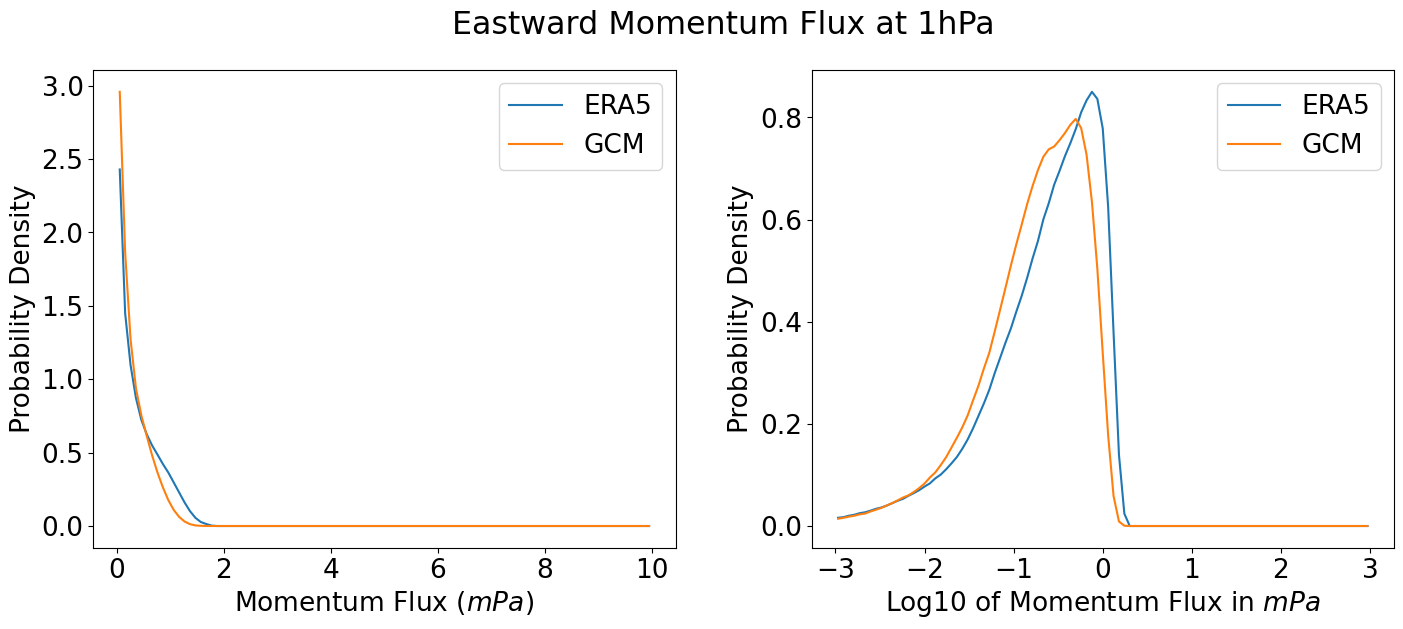

In [22]:
fig,axs = plt.subplots(1,2,figsize=(15,6.5))
fig.tight_layout(pad=2.4)
axs = axs.ravel()
fig.suptitle(f"Eastward Momentum Flux at {LEVEL}hPa {basin_title}")
# plot_mass(era5_eastward_lvl,gcm_eastward_lvl,loon='u_flux_ptv',ax=axs[0])
plot_density(era5_eastward_lvl,gcm_eastward_lvl,loon='u_flux_ptv' if LEVEL == 50 else None,ax=axs[0])
# plot_density_ylog(era5_eastward_lvl,gcm_eastward_lvl,loon='u_flux_ptv',ax=axs[2])
plot_logx_density(era5_eastward_lvl,gcm_eastward_lvl,loon='u_flux_ptv' if LEVEL == 50 else None ,ax=axs[1])

fig.savefig(os.path.join(FIGDIR,f'{expcode}_uptv_fluxes_{LEVEL}_{'_'.join(BASINS) if BASINS else 'all'}.png'),dpi=300)


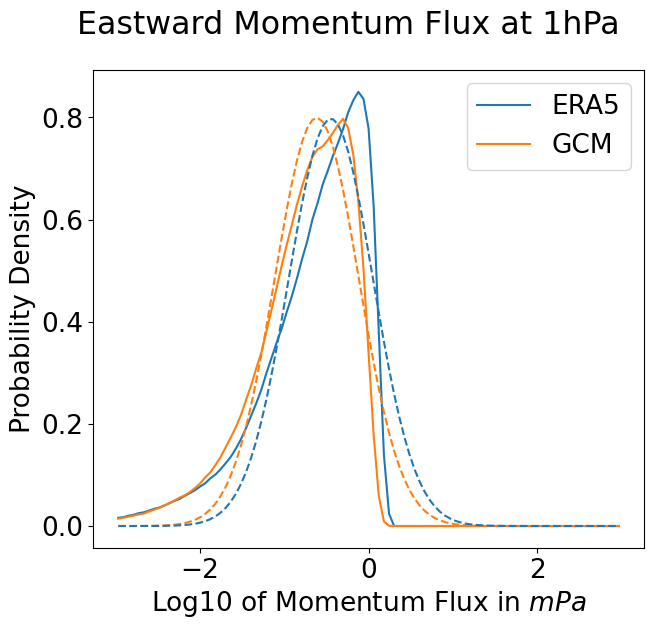

In [23]:
fig,ax = plt.subplots(1,1,figsize=(7.5,6.5))
fig.tight_layout(pad=2.4)

fig.suptitle(f"Eastward Momentum Flux at {LEVEL}hPa {basin_title}")
# plot_mass(era5_eastward_lvl,gcm_eastward_lvl,loon='u_flux_ptv',ax=axs[0])
# plot_density(era5_eastward_lvl,gcm_eastward_lvl,loon='u_flux_ptv' if LEVEL == 50 else None,ax=axs[0])
# plot_density_ylog(era5_eastward_lvl,gcm_eastward_lvl,loon='u_flux_ptv',ax=axs[2])
plot_logx_density_w_nonlinear_fit(era5_eastward_lvl,gcm_eastward_lvl,loon='u_flux_ptv' if LEVEL == 50 else None ,ax=ax)

fig.savefig(os.path.join(FIGDIR,f'{expcode}_uptv_fluxes_{LEVEL}_{'_'.join(BASINS) if BASINS else 'all'}_wnonlinearfit.png'),dpi=300)


eastward (numerics)

In [24]:
pretty_print_stats(era5_eastward_lvl,gcm_eastward_lvl,'u_flux_ptv')

------------ Statistics ------------
--------------- Total --------------
ERA5 ----------- GCM ---------- Loon
1352.97 Pa    924.69 Pa       3594.50 Pa
37.64 %        25.73 %          100%
--------------- Mean  --------------
ERA5 ----------- GCM ---------- Loon
0.41 mPa    0.30 mPa       1.79 mPa
23.03 %        16.75 %          100%
-0.67 logmPa    -0.79 logmPa       0.38 logmPa
-174.63 %        -206.12 %          100%


westward

In [25]:
era5_westward_lvl = ds_era5.gw_flux_westward.sel(level=LEVEL).data.ravel()
gcm_westward_lvl = ds_gcm.gw_flux_westward.sel(level=LEVEL).data.ravel()
era5_westward_lvl = filter_scale(era5_westward_lvl)
gcm_westward_lvl= filter_scale(gcm_westward_lvl)


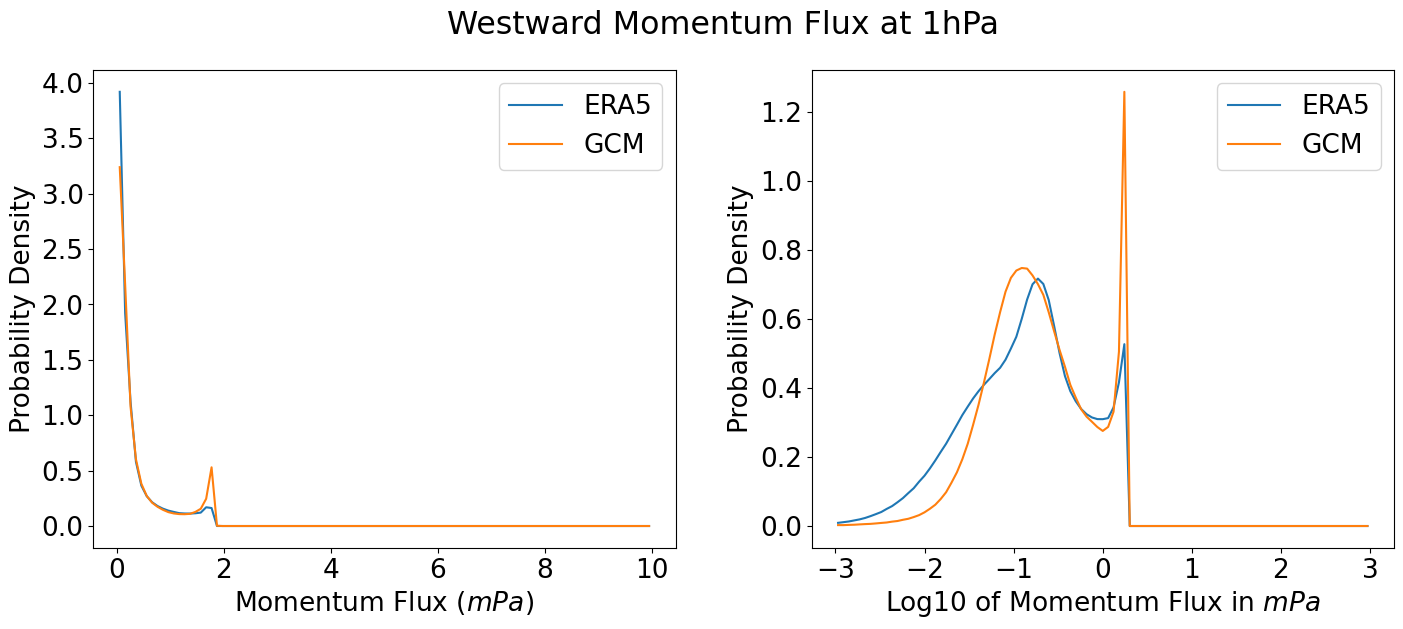

In [26]:
fig,axs = plt.subplots(1,2,figsize=(15,6.5))
fig.tight_layout(pad=2.4)
axs = axs.ravel()
fig.suptitle(f"Westward Momentum Flux at {LEVEL}hPa {basin_title}")

plot_density(era5_westward_lvl,gcm_westward_lvl,loon='u_flux_ntv' if LEVEL == 50 else None,ax=axs[0])
plot_logx_density(era5_westward_lvl,gcm_westward_lvl,loon='u_flux_ntv' if LEVEL == 50 else None,ax=axs[1])

fig.savefig(os.path.join(FIGDIR,f'{expcode}_untv_fluxes_{LEVEL}_{'_'.join(BASINS) if BASINS else 'all'}.png'),dpi=300)


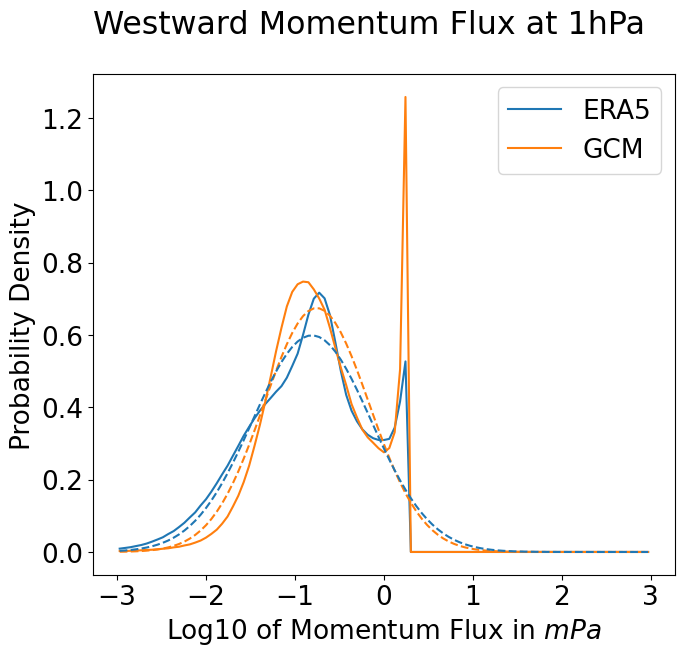

In [27]:
fig, ax = plt.subplots(1,1,figsize=(7.5,6.5))
plot_logx_density_w_nonlinear_fit(era5_westward_lvl,gcm_westward_lvl,loon='u_flux_ntv' if LEVEL == 50 else None,ax=ax)
fig.suptitle(f"Westward Momentum Flux at {LEVEL}hPa {basin_title}")
fig.savefig(os.path.join(FIGDIR,f'{expcode}_untv_fluxes_{LEVEL}_{'_'.join(BASINS) if BASINS else 'all'}_wfit.png'),dpi=300)

northward

In [82]:
era5_northward_lvl = ds_era5.gw_flux_northward.sel(level=LEVEL).data.ravel()
gcm_northward_lvl = ds_gcm.gw_flux_northward.sel(level=LEVEL).data.ravel()
era5_northward_lvl = filter_scale(era5_northward_lvl)
gcm_northward_lvl= filter_scale(gcm_northward_lvl)



In [ ]:
fig,axs = plt.subplots(1,2,figsize=(14,6))
fig.tight_layout(pad=2.4)
axs = axs.ravel()
fig.suptitle(f"Northward Momentum Flux at {LEVEL}hPa {basin_title}")

plot_density(era5_northward_lvl,gcm_northward_lvl,loon='v_flux_ptv' if LEVEL == 50 else None,ax=axs[0])
plot_logx_density(era5_northward_lvl,gcm_northward_lvl,loon='v_flux_ptv' if LEVEL == 50 else None,ax=axs[1])

fig.savefig(os.path.join(FIGDIR,f'{expcode}_vptv_fluxes_{LEVEL}_{'_'.join(BASINS) if BASINS else 'all'}.png'),dpi=300)


southward

In [84]:
era5_southward_lvl = ds_era5.gw_flux_southward.sel(level=LEVEL).data.ravel()
gcm_southward_lvl = ds_gcm.gw_flux_southward.sel(level=LEVEL).data.ravel()
era5_southward_lvl = filter_scale(era5_southward_lvl)
gcm_southward_lvl= filter_scale(gcm_southward_lvl)


In [ ]:
fig,axs = plt.subplots(1,2,figsize=(14,6))
fig.tight_layout(pad=2.4)
axs = axs.ravel()
fig.suptitle(f"Southward Momentum Flux at {LEVEL}hPa {basin_title}")

plot_density(era5_southward_lvl,gcm_southward_lvl,loon='v_flux_ntv' if LEVEL == 50 else None,ax=axs[0])
plot_logx_density(era5_southward_lvl,gcm_southward_lvl,loon='v_flux_ntv' if LEVEL == 50 else None,ax=axs[1])

fig.savefig(os.path.join(FIGDIR,f'{expcode}_vntv_fluxes_{LEVEL}_{'_'.join(BASINS) if BASINS else 'all'}.png'),dpi=300)


net

In [86]:
era5_net_lvl = net_era5.sel(level=LEVEL).data.ravel()
gcm_net_lvl = net_gcm.sel(level=LEVEL).data.ravel()
era5_net_lvl = filter_scale(era5_net_lvl)
gcm_net_lvl= filter_scale(gcm_net_lvl)


In [ ]:
fig,axs = plt.subplots(1,2,figsize=(14,6))
fig.tight_layout(pad=2.4)
axs = axs.ravel()
fig.suptitle(f"Net Momentum Flux at {LEVEL}hPa {basin_title}")

plot_density(era5_net_lvl,gcm_net_lvl,loon='net_flux' if LEVEL == 50 else None,ax=axs[0])
plot_logx_density(era5_net_lvl,gcm_net_lvl,loon='net_flux' if LEVEL == 50 else None,ax=axs[1])

fig.savefig(os.path.join(FIGDIR,f'{expcode}_net_fluxes_{LEVEL}_{'_'.join(BASINS) if BASINS else 'all'}.png'),dpi=300)


###  total
#### (all cardinal directions)

In [88]:
era5_abs_lvl = total_era5.sel(level=LEVEL).data.ravel()
gcm_abs_lvl = total_gcm.sel(level=LEVEL).data.ravel()
era5_abs_lvl = filter_scale(era5_abs_lvl)
gcm_abs_lvl= filter_scale(gcm_abs_lvl)


In [ ]:
fig,axs = plt.subplots(1,2,figsize=(14,6))
fig.tight_layout(pad=2.4)
axs = axs.ravel()
fig.suptitle(f"Total absolute momentum flux at {LEVEL}hPa {basin_title}")

plot_density(era5_abs_lvl,gcm_abs_lvl,loon='abs_flux' if LEVEL == 50 else None,ax=axs[0])
plot_logx_density(era5_abs_lvl,gcm_abs_lvl,loon='abs_flux' if LEVEL == 50 else None ,ax=axs[1])

fig.savefig(os.path.join(FIGDIR,f'{expcode}_total_fluxes_{LEVEL}_{'_'.join(BASINS) if BASINS else 'all'}.png'),dpi=300)


#### Zonal

In [90]:
zonal_total_gcm =np.abs(ds_gcm.gw_flux_eastward ) + np.abs(ds_gcm.gw_flux_westward )
zonal_total_era5 =np.abs(ds_era5.gw_flux_eastward ) + np.abs(ds_era5.gw_flux_westward )
zonal_total_gcm_lvl = zonal_total_gcm.sel(level=LEVEL).data.ravel()
zonal_total_era5_lvl = zonal_total_era5.sel(level=LEVEL).data.ravel()

zonal_total_gcm_lvl = filter_scale(zonal_total_gcm_lvl)
zonal_total_era5_lvl = filter_scale(zonal_total_era5_lvl)

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(14,6))
fig.tight_layout(pad=2.4)
axs = axs.ravel()
fig.suptitle(f"Total absolute zonal momentum flux at {LEVEL}hPa {basin_title}")

plot_density(zonal_total_era5_lvl  ,zonal_total_gcm_lvl,loon='abs_flux' if LEVEL == 50 else None,ax=axs[0])
plot_logx_density(zonal_total_era5_lvl ,zonal_total_gcm_lvl,loon='abs_flux' if LEVEL == 50 else None,ax=axs[1])

fig.savefig(os.path.join(FIGDIR,f'{expcode}_total_zonal_fluxes_{LEVEL}_{'_'.join(BASINS) if BASINS else 'all'}.png'),dpi=300)


#### Meridional

In [92]:
merid_total_gcm =np.abs(ds_gcm.gw_flux_southward ) + np.abs(ds_gcm.gw_flux_northward )
merid_total_era5 =np.abs(ds_era5.gw_flux_southward ) + np.abs(ds_era5.gw_flux_northward)

merid_total_gcm_lvl = merid_total_gcm.sel(level=LEVEL).data.ravel()
merid_total_era5_lvl = merid_total_era5.sel(level=LEVEL).data.ravel()

merid_total_gcm_lvl = filter_scale(merid_total_gcm_lvl)
merid_total_era5_lvl = filter_scale(merid_total_era5_lvl)

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(14,6))
fig.tight_layout(pad=2.4)
axs = axs.ravel()
fig.suptitle(f"Total absolute meridional momentum flux at {LEVEL}hPa {basin_title}")

plot_density(merid_total_era5_lvl  ,merid_total_gcm_lvl,loon='abs_flux' if LEVEL == 50 else None,ax=axs[0])
plot_logx_density(merid_total_era5_lvl ,merid_total_gcm_lvl,loon='abs_flux' if LEVEL == 50 else None,ax=axs[1])

fig.savefig(os.path.join(FIGDIR,f'{expcode}_total_merid_fluxes_{LEVEL}_{'_'.join(BASINS) if BASINS else 'all'}.png'),dpi=300)
